LSTM NEURAL NETWORK

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.1676 - val_loss: 0.0258
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0040 - val_loss: 0.0075
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.

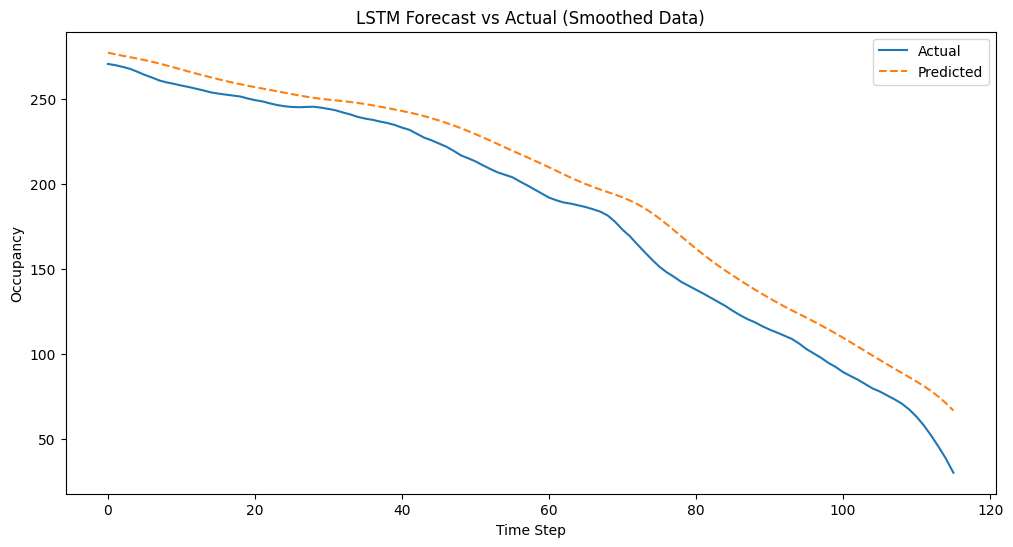

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = r"C:\Users\hp\Downloads\hospital_patient_flow.csv"  # Update with your file path
df = pd.read_csv(file_path)

# Convert timestamps to datetime
df['Admission_Timestamp'] = pd.to_datetime(df['Admission_Timestamp'])
df['Discharge_Timestamp'] = pd.to_datetime(df['Discharge_Timestamp'])

# Calculate Length of Stay in days
df['Length_of_Stay'] = (df['Discharge_Timestamp'] - df['Admission_Timestamp']).dt.days + 1
df = df[df['Length_of_Stay'] > 0]

# Expand dataset to daily occupancy
all_dates = pd.date_range(start=df['Admission_Timestamp'].min(), 
                          end=df['Discharge_Timestamp'].max())
occupancy_df = pd.DataFrame({'Date': all_dates})
occupancy_df['Occupancy'] = 0

for _, row in df.iterrows():
    mask = (occupancy_df['Date'] >= row['Admission_Timestamp']) & \
           (occupancy_df['Date'] < row['Admission_Timestamp'] + pd.Timedelta(days=row['Length_of_Stay']))
    occupancy_df.loc[mask, 'Occupancy'] += 1

# Smooth the data using a rolling average
rolling_window = 7  # Hyperparameter: Rolling window size
occupancy_df['Smoothed_Occupancy'] = occupancy_df['Occupancy'].rolling(window=rolling_window).mean()
occupancy_df.dropna(inplace=True)  # Drop NaN values caused by rolling average

# Prepare data
occupancy_df.set_index('Date', inplace=True)
data = occupancy_df['Smoothed_Occupancy'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Train-test split
train_size = int(len(data_normalized) * 0.8)
train, test = data_normalized[:train_size], data_normalized[train_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Hyperparameter: Sequence length
seq_length = 30
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Build the LSTM model
# Hyperparameters: LSTM units, dropout rates
lstm_units = 128
dropout_rate = 0.3

model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(dropout_rate),
    LSTM(lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
# Hyperparameter: Batch size
batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# Forecast
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(predictions_rescaled, label="Predicted", linestyle='--')
plt.title("LSTM Forecast vs Actual (Smoothed Data)")
plt.xlabel("Time Step")
plt.ylabel("Occupancy")
plt.legend()
plt.show()


ARIMA MODEL

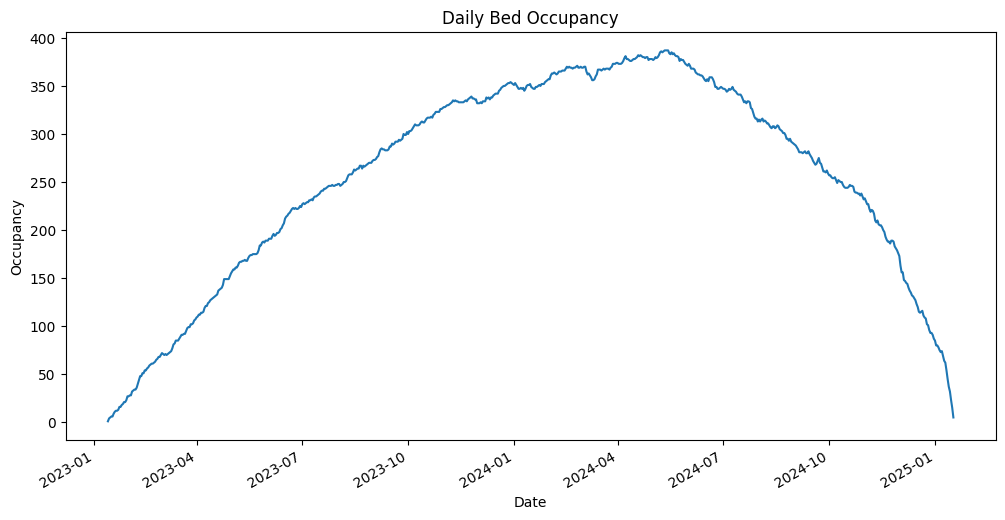

Performing ARIMA hyperparameter tuning...


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) -> MAE: 76.48, RMSE: 104.57


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) -> MAE: 76.34, RMSE: 104.48


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) -> MAE: 75.98, RMSE: 104.24
ARIMA(0, 1, 0) -> MAE: 102.26, RMSE: 128.10
ARIMA(0, 1, 1) -> MAE: 101.92, RMSE: 127.82


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\stat

ARIMA(0, 1, 2) -> MAE: 101.50, RMSE: 127.49
ARIMA(0, 2, 0) -> MAE: 46.74, RMSE: 51.78


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\stat

ARIMA(0, 2, 1) -> MAE: 39.70, RMSE: 58.80


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) -> MAE: 39.89, RMSE: 59.01


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0) -> MAE: 102.14, RMSE: 127.96


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) -> MAE: 101.78, RMSE: 127.66


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) -> MAE: 101.34, RMSE: 127.30
ARIMA(1, 1, 0) -> MAE: 101.51, RMSE: 127.49


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\stat

ARIMA(1, 1, 1) -> MAE: 44.75, RMSE: 64.97


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) -> MAE: 44.87, RMSE: 65.09
ARIMA(1, 2, 0) -> MAE: 24.29, RMSE: 29.07


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\stat

ARIMA(1, 2, 1) -> MAE: 39.91, RMSE: 59.03


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

ARIMA(1, 2, 2) -> MAE: 39.63, RMSE: 58.72


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) -> MAE: 101.34, RMSE: 127.29


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

ARIMA(2, 0, 1) -> MAE: 101.99, RMSE: 127.84


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Li

ARIMA(2, 0, 2) -> MAE: 387.77, RMSE: 487.21
ARIMA(2, 1, 0) -> MAE: 100.19, RMSE: 126.42
ARIMA(2, 1, 1) -> MAE: 44.88, RMSE: 65.10


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

ARIMA(2, 1, 2) -> MAE: 44.52, RMSE: 64.76
ARIMA(2, 2, 0) -> MAE: 19.69, RMSE: 24.07


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\stat

ARIMA(2, 2, 1) -> MAE: 40.63, RMSE: 59.82


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

ARIMA(2, 2, 2) -> MAE: 40.73, RMSE: 59.93
Best ARIMA Order: (2, 2, 0), RMSE: 24.07


SyntaxError: 'continue' not properly in loop (1214686657.py, line 80)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from itertools import product

# Load the dataset
file_path = r"C:\Users\hp\Downloads\hospital_patient_flow.csv"  # Update with your file path
df = pd.read_csv(file_path)

# Convert timestamps to datetime
df['Admission_Timestamp'] = pd.to_datetime(df['Admission_Timestamp'])
df['Discharge_Timestamp'] = pd.to_datetime(df['Discharge_Timestamp'])

# Calculate Length of Stay in days
df['Length_of_Stay'] = (df['Discharge_Timestamp'] - df['Admission_Timestamp']).dt.days + 1
df = df[df['Length_of_Stay'] > 0]

# Expand dataset using vectorized operations
all_dates = pd.date_range(start=df['Admission_Timestamp'].min(), 
                          end=df['Discharge_Timestamp'].max())
occupancy_df = pd.DataFrame({'Date': all_dates})
occupancy_df['Occupancy'] = 0

# Ensure 'Date' in occupancy_df and comparison values are the same type
for _, row in df.iterrows():
    mask = (occupancy_df['Date'] >= row['Admission_Timestamp']) & \
           (occupancy_df['Date'] < row['Admission_Timestamp'] + pd.Timedelta(days=row['Length_of_Stay']))
    occupancy_df.loc[mask, 'Occupancy'] += 1

# Group by Date
daily_occupancy = occupancy_df.set_index('Date')['Occupancy']

# Plot the daily occupancy
plt.figure(figsize=(12, 6))
daily_occupancy.plot(title="Daily Bed Occupancy", ylabel="Occupancy", xlabel="Date")
plt.show()

# Train-test split
train_size = int(len(daily_occupancy) * 0.8)
train, test = daily_occupancy[:train_size], daily_occupancy[train_size:]

# Function for ARIMA hyperparameter tuning
def evaluate_arima_model(order, train, test):
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        return mae, rmse
    except Exception as e:
        return float("inf"), float("inf")

# Define hyperparameter ranges
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]
best_score = float("inf")
best_order = None

# Perform grid search for hyperparameters
print("Performing ARIMA hyperparameter tuning...")
for order in product(p_values, d_values, q_values):
    mae, rmse = evaluate_arima_model(order, train, test)
    if rmse < best_score:
        best_score = rmse
        best_order = order
    print(f"ARIMA{order} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print(f"Best ARIMA Order: {best_order}, RMSE: {best_score:.2f}")



# Fit the best ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecast with confidence intervals
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Extract lower and upper bounds
lower_bounds = confidence_intervals.iloc[:, 0]
upper_bounds = confidence_intervals.iloc[:, 1]

# Plot historical data with forecast and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test.index, test, label="Testing Data", color='orange')
plt.plot(test.index, forecast, label="Forecast", linestyle='--', color='green')
plt.fill_between(test.index, lower_bounds, upper_bounds, color='green', alpha=0.2)
plt.title(f"ARIMA{best_order} Bed Occupancy Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Occupancy")
plt.legend()
plt.show()

# Evaluate forecast performance
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / (test + 1e-10))) * 100  # Avoid division by zero

# Print the metrics
print(f"Evaluation Metrics for ARIMA{best_order}:")
print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
